**TRAIN THE ARTERY VEIN SEGMENTATION MODEL**

In [1]:
!pip install patchify

import os
import glob
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import tensorflow as tf
import random

np.random.seed(0) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
PATH = '/content/drive/MyDrive/AV_split/'

TRAIN_PATH = PATH+'train_av/'
TRAIN_PREDICTED_VESSEL_PATH = PATH + 'predicted_vessel/'
TRAIN_VESSEL_MASK_PATH = TRAIN_PATH + 'GT_vessel/'
TRAIN_ARTERY_MASK_PATH = TRAIN_PATH + 'GT_artery/'
TRAIN_VEIN_MASK_PATH = TRAIN_PATH + 'GT_vein/'

TEST_PATH = PATH+'test/'
TEST_IMAGE_PATH = TEST_PATH + 'images/'
TEST_VESSEL_MASK_PATH = TEST_PATH + 'GT_vessel/'
TEST_ARTERY_MASK_PATH = TEST_PATH + 'GT_artery/'
TEST_VEIN_MASK_PATH = TEST_PATH + 'GT_vein/'

PATCH_SIZE = 512

VEIN_COLOR = [0, 0, 255]      
ARTERY_COLOR = [255, 0, 0]     
BLACK_BG_COLOR = [0, 0, 0]
VESSEL_COLOR = [255, 255, 255]

SAVE_MODEL = PATH + 'model/'
SAVE_AV_MODEL_NAME = SAVE_MODEL + 'unet-av.h5'
SAVE_VESSEL_MODEL_NAME = SAVE_MODEL + 'unet-vessel.h5'

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def clahe_equalized(image):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    image_equalized = clahe.apply(image)

    return image_equalized

def preprocess_image(image, patch_size):
    image = image[70:970, 200:1255]

    image = image[:,:,1]
    image = clahe_equalized(image)

    SIZE_X = (image.shape[1]//patch_size)*patch_size 
    SIZE_Y = (image.shape[0]//patch_size)*patch_size     
    image = cv2.resize(image, (SIZE_X, SIZE_Y))
    
    image = image / 255.
    image = np.array(image)

    return image

In [5]:
def vessel_image_to_patch(image_path, patch_size):
    image_dataset = unpatched_image = []

    image = cv2.imread(image_path)

    patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    unpatched_image = unpatchify(patches_image, image.shape)
    
    for i in range(patches_image.shape[0]):
        for j in range(patches_image.shape[1]):
            single_patch = patches_image[i,j,:,:]
            single_patch = (single_patch).astype('float32') / 255.
            image_dataset.append(single_patch[0])

    return image_dataset, unpatched_image

In [6]:
def preprocess_vessel_mask(mask, patch_size):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    mask = mask[70:970, 200:1255]
    
    SIZE_X = (mask.shape[1]//patch_size)*patch_size 
    SIZE_Y = (mask.shape[0]//patch_size)*patch_size     

    mask = cv2.resize(mask, (SIZE_X, SIZE_Y))
  
    mask = 255 - mask
    mask = mask / 255

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

def preprocess_vein_mask(image, patch_size):
    mask = preprocess_vessel_mask(image, patch_size)

    mask = (mask).astype('uint8')
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255

    mask[np.all(mask == VESSEL_COLOR, axis=-1)] = VEIN_COLOR

    return (mask).astype('float32')

def preprocess_artery_mask(image, patch_size):
    mask = preprocess_vessel_mask(image, patch_size)

    mask = (mask).astype('uint8')
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255

    mask[np.all(mask == VESSEL_COLOR, axis=-1)] = ARTERY_COLOR

    return (mask).astype('float32')

def merge_and_mask_labeling(vein_mask, artery_mask):
    result = cv2.add(vein_mask, artery_mask)

    mask_label = np.zeros(result.shape, dtype=np.uint8)
    mask_label[np.all(result == ARTERY_COLOR, axis=-1)] = 1
    mask_label[np.all(result == VEIN_COLOR, axis=-1)] = 2                                   

    return result, mask_label[:,:,0]                                            

def mask_to_patch(vein_path, artery_path, patch_size, visualize = False):
    mask_dataset = []

    vein_image = cv2.imread(vein_path, cv2.IMREAD_GRAYSCALE)
    vein_mask = preprocess_vein_mask(vein_image, patch_size)

    artery_image = cv2.imread(artery_path, cv2.IMREAD_GRAYSCALE)
    artery_mask = preprocess_artery_mask(artery_image, patch_size)

    if visualize:
        merged_mask, _ = merge_and_mask_labeling(vein_mask, artery_mask)
    else:
        _, merged_mask = merge_and_mask_labeling(vein_mask, artery_mask)

    patches_mask = patchify(merged_mask, (patch_size, patch_size), step=patch_size)
    unpatched_mask = unpatchify(patches_mask, merged_mask.shape)
    
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch = patches_mask[i,j,:,:]
            single_patch = (single_patch).astype('float32')
            mask_dataset.append(single_patch)

    return mask_dataset, unpatched_mask

In [7]:
train_av_image_paths = glob.glob(TRAIN_PREDICTED_VESSEL_PATH + "/*.JPG")
train_av_image_paths.sort()

train_av_vessel_paths = glob.glob(TRAIN_VESSEL_MASK_PATH + "/*.jpg")
train_av_vessel_paths.sort()

train_av_artery_paths = glob.glob(TRAIN_ARTERY_MASK_PATH + "/*.jpg")
train_av_artery_paths.sort()

train_av_vein_paths = glob.glob(TRAIN_VEIN_MASK_PATH + "/*.jpg")
train_av_vein_paths.sort()

In [8]:
train_image_dataset = []
train_mask_dataset = []

for image_path in train_av_image_paths:
    patched_image, unpatched_image = vessel_image_to_patch(image_path, PATCH_SIZE)
    train_image_dataset += patched_image

for (vein_mask_path, artery_mask_path) in zip(train_av_vein_paths, train_av_artery_paths):
    patched_mask, unpatched_mask = mask_to_patch(vein_mask_path, artery_mask_path, PATCH_SIZE, visualize = False)
    train_mask_dataset += patched_mask

train_image_dataset = np.array(train_image_dataset)
train_mask_dataset = np.array(train_mask_dataset)

print(train_image_dataset.shape)
print(train_mask_dataset.shape)
print(train_image_dataset.max(), train_mask_dataset.max())
print(train_image_dataset.min(), train_mask_dataset.min())

(80, 512, 512, 3)
(80, 512, 512)
1.0 2.0
0.0 0.0


In [9]:
from tensorflow.keras.utils import to_categorical

n_classes = len(np.unique(train_mask_dataset))
mask_categories = to_categorical(train_mask_dataset, num_classes=n_classes)

print(np.unique(mask_categories))
print(mask_categories.shape)

[0. 1.]
(80, 512, 512, 3)


<Figure size 360x360 with 0 Axes>

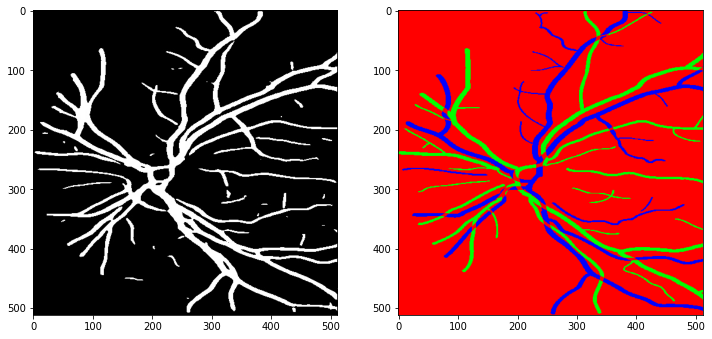

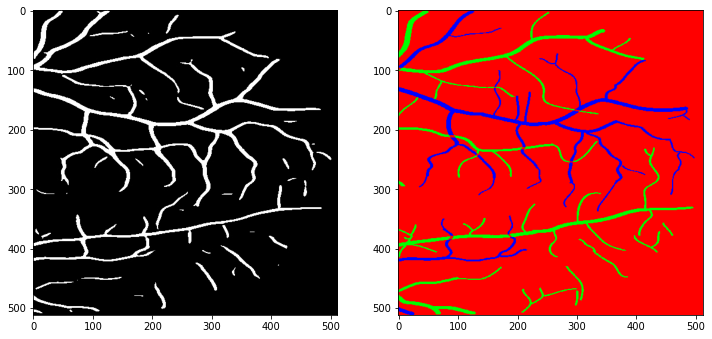

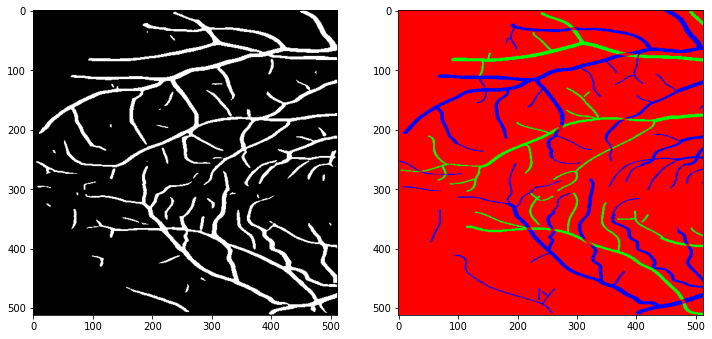

In [10]:
fig = plt.figure(figsize=(5, 5))
for i in range(1, 4):
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.imshow(train_image_dataset[i-1])

    plt.subplot(122)
    plt.imshow(mask_categories[i-1])
    
    plt.show()
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_image_dataset, mask_categories, test_size=0.2, random_state=0)

In [12]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(64, 512, 512, 3) (64, 512, 512, 3)
(16, 512, 512, 3) (16, 512, 512, 3)


In [13]:
IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]

print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

512 512 3


In [14]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(y_true * y_pred, axis = [1,2,3])
    union = K.sum(y_true, axis = [1,2,3]) + K.sum(y_pred, axis = [1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis = 0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

In [15]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def unet_multi(pretrained_weights = None, input_size = (512,512,3), n_class = 3):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
       
    conv10 = Conv2D(n_class, (1,1), activation = 'softmax')(conv9)
    
 
    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 0.0001), loss = ['binary_crossentropy'], metrics = ['accuracy'])    

    if(pretrained_weights):
    	model = keras.models.load_model(pretrained_weights)

    return model

In [16]:
model = unet_multi(n_class = n_classes)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
history = model.fit(x_train, y_train, 
                    batch_size = 3, 
                    verbose = 1, 
                    epochs = 150, 
                    validation_data = (x_test, y_test), 
                    steps_per_epoch = 10,
                    shuffle = False)

Epoch 1/150
10/10 [==============================] - 47s 2s/step - loss: 0.3944 - accuracy: 0.8166 - val_loss: 0.3492 - val_accuracy: 0.8746
Epoch 2/150
10/10 [==============================] - 13s 1s/step - loss: 0.1926 - accuracy: 0.8891 - val_loss: 0.3713 - val_accuracy: 0.8755
Epoch 3/150
10/10 [==============================] - 17s 2s/step - loss: 0.1888 - accuracy: 0.8880 - val_loss: 0.4115 - val_accuracy: 0.8662
Epoch 4/150
10/10 [==============================] - 13s 1s/step - loss: 0.1743 - accuracy: 0.8963 - val_loss: 0.3211 - val_accuracy: 0.8764
Epoch 5/150
10/10 [==============================] - 12s 1s/step - loss: 0.1784 - accuracy: 0.8932 - val_loss: 0.2527 - val_accuracy: 0.8926
Epoch 6/150
10/10 [==============================] - 13s 1s/step - loss: 0.1761 - accuracy: 0.8967 - val_loss: 0.1883 - val_accuracy: 0.8922
Epoch 7/150
10/10 [==============================] - 12s 1s/step - loss: 0.1738 - accuracy: 0.8949 - val_loss: 0.1902 - val_accuracy: 0.8928
Epoch 8/150
1

In [18]:
# IOU
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

# Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU

n_classes = len(np.unique(train_mask_dataset))
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 23s 23s/step
Mean IoU = 0.46975303


1/1 [==============================] - 0s 24ms/step
(512, 512)
[0 1 2]


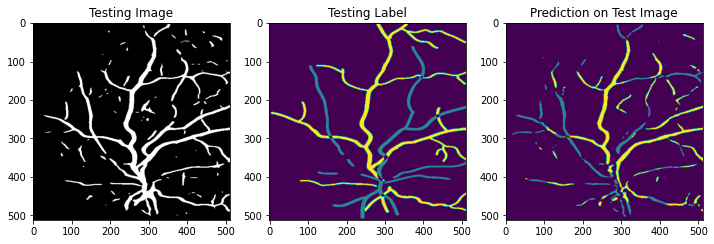

In [19]:
import random

test_img_number = random.randint(0, len(x_test))
test_img = x_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]

test_img_input = np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

print(predicted_img.shape)
print(np.unique(predicted_img))

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img)
plt.show()

In [20]:
from keras.models import load_model

if not os.path.exists(SAVE_MODEL):
      os.makedirs(SAVE_MODEL)

model.save(SAVE_AV_MODEL_NAME)

**PREDICT FROM RAW IMAGE**

In [39]:
test_image_list = glob.glob(TEST_IMAGE_PATH + '/*.JPG')
test_image_list.sort()

test_vessel_list = glob.glob(TEST_VESSEL_MASK_PATH + '/*.JPG')
test_vessel_list.sort()

test_vein_mask_list = glob.glob(TEST_VEIN_MASK_PATH + '/*.jpg')
test_vein_mask_list.sort()

test_artery_mask_list = glob.glob(TEST_ARTERY_MASK_PATH + '/*.jpg')
test_artery_mask_list.sort()

1/1 [==============================] - 0s 33ms/step


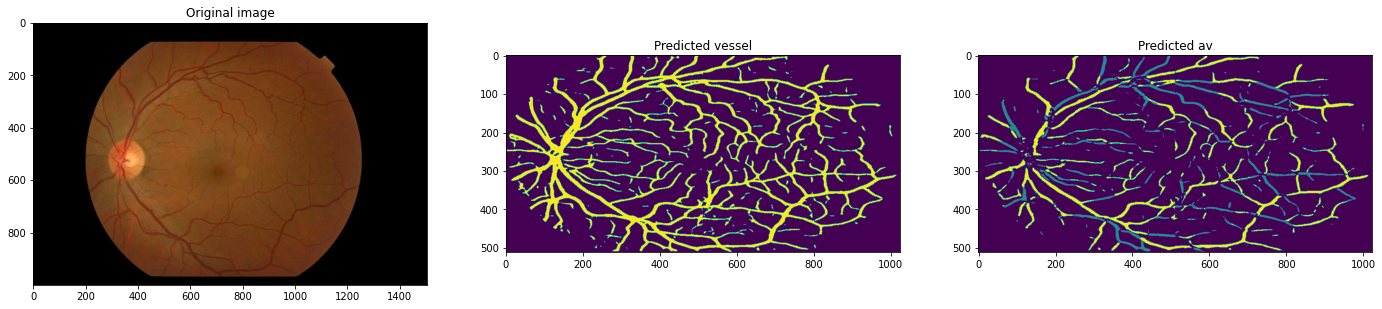

In [38]:
from datetime import datetime
from tensorflow.keras.utils import get_custom_objects
from keras.models import load_model

test_image_number = random.randint(0, len(test_image_list)-1)
test_image_path = test_image_list[test_image_number]
test_image = cv2.imread(test_image_path)

# load vessel model
get_custom_objects().update({'IoU_loss': IoU_loss})
get_custom_objects().update({'IoU_coef': IoU_coef})
vessel_model = load_model(SAVE_VESSEL_MODEL_NAME)

get_custom_objects().update({'dice_coef': dice_coef})
get_custom_objects().update({'dice_coef_loss': dice_coef_loss})
av_model = load_model(SAVE_AV_MODEL_NAME)

# predict the vessel
predicted_patches = []
start = datetime.now()   

test = preprocess_image(test_image, PATCH_SIZE)
patches = patchify(test, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE) 

for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) 
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (vessel_model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
          predicted_patches.append(single_patch_prediction)
          
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], PATCH_SIZE, PATCH_SIZE))
reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) 

# predict the artery vein
vessel_image_dataset = []

rgb_image = (reconstructed_image).astype('uint8')
rgb_image = cv2.cvtColor(reconstructed_image, cv2.COLOR_GRAY2RGB) * 255
patches_rgb_image = patchify(rgb_image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)

for i in range(patches_rgb_image.shape[0]):
  for j in range(patches_rgb_image.shape[1]):
      single_patch = patches_rgb_image[i,j,:,:]
      single_patch = (single_patch).astype('float32') / 255.
      vessel_image_dataset.append(single_patch[0])

predicted_av_list = []

for test_vessel in vessel_image_dataset:
    test_img_input = np.expand_dims(test_vessel, 0)
    prediction = (av_model.predict(test_img_input))
    predicted_av = np.argmax(prediction, axis=3)[0,:,:]
    predicted_av_list.append(predicted_av)

predicted_av = np.array(predicted_av_list)
predicted_av_reshaped = np.reshape(predicted_av, (patches.shape[0], patches.shape[1], PATCH_SIZE, PATCH_SIZE))
reconstructed_av_image = unpatchify(predicted_av_reshaped, (512, 1024)) 

plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Original image')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.title('Predicted vessel')
plt.imshow(reconstructed_image)
plt.subplot(233)
plt.title('Predicted av')
plt.imshow(reconstructed_av_image)
plt.show()

plt.figure(figsize=(24, 12))
plt.subplot(231)
plt.title('Original image')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.title('Predicted vessel')
plt.imshow(reconstructed_image)
plt.subplot(233)
plt.title('Predicted av')
plt.imshow(reconstructed_av_image)
plt.show()